# Лаб. вежба 8: Класификација на квалитет на вино

### Студент: Александар Ивановски
### Индекс: 186063
### Група: Компјутерски науки

<hr>

## 1. Import-и и помошни функции

### 1.1. Import-и

In [157]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, MaxPooling1D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras import Input
from tensorflow.keras import layers, optimizers, regularizers


### 1.2. Помошни функции

In [2]:
def one_hot_encoder(f):
    """
    Funkcija za one-hot enkodiranje vo tri klasi:
        bad: (0-5)
        normal: 6
        good: (7-10)
        
    """
    if f < 6:
        return [1,0,0]
    if f == 6:
        return [0,1,0]
    else:
        return [0,0,1]

In [3]:
def split_subset(subset):
    """
        Funkcija koja prima podmnozestvo od podatoci i vraka dva dataframe-ovi, taka sto edniot e karakteristikite,
        a drugiot se klasnite labeli. Analogno so X, Y vo prethodnite vezbi.
    """
    return (subset[subset.columns[0:-1]], subset[subset.columns[-1:]])

In [4]:
def convert_to_numpyarr(pandas_df):
    """
        Funkcija koja sto pretvora pandas serija vo numpy array
    """
    return np.array([t[0] for t in pandas_df.values.tolist()])

In [58]:
def visualize(hist, metric):
    """
        Funkcija za vizuelizacija na dadena metrika
    """
    plt.rcParams["figure.figsize"] = (30,10)
    plt.plot(hist.history[f'{metric}'])
    plt.plot(hist.history[f'val_{metric}'])
    plt.title(f'Model {metric}')
    plt.ylabel(f'{metric}')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [172]:
def evaluate_model(model, test_y):
    """
        Funkcija za evaluacija na modelot, odnosno presmetka na:
            - accuracy
            - precision
            - f1 score
            - recall
    """
    test_y_classes_pred = model.predict_classes(test_x).tolist()
    test_y_classes_actual = [np.argmax(pred) for pred in test_y.tolist()]
    accuracy = accuracy_score(test_y_classes_actual, test_y_classes_pred)
    precision = precision_score(test_y_classes_actual, test_y_classes_pred,  average='macro',labels=[0,1,2])
    f1 = f1_score(test_y_classes_actual, test_y_classes_pred, average='macro',labels=[0,1,2])
    recall = recall_score(test_y_classes_actual, test_y_classes_pred, average='macro', labels=[0,1,2])
    return (accuracy, precision, f1, recall)

In [173]:
def print_evaluation(evaluation):
    """
        Funkcija za pecatenje na evaluiranite metriki od `evaluate_model`
    """
    print("Accuracy:{}".format(evaluation[0]))
    print("Precision:{}".format(evaluation[1]))
    print("F1 score:{}".format(evaluation[2]))
    print("Recall:{}".format(evaluation[3]))

In [178]:
def compare_metrics(metrics1, metrics2):
    """
        Funkcija za sporedba na metrikite na dva modeli
    """
    ret_comparation = []
    for (m1,m2) in zip(metrics1,metrics2):
        ret_comparation.append(m1-m2)

    return ret_comparation

In [189]:
def print_comparation(comp):
    """
        Funkcija za pecatenje na sporedbata na metrikite na dva modeli
    """
    print("Δ Accuracy:{}".format(comp[0]))
    print("Δ Precision:{}".format(comp[1]))
    print("Δ F1 score:{}".format(comp[2]))
    print("Δ Recall:{}".format(comp[3]))

## 2. Вчитување на податоците

In [5]:
DATASET_PATH = 'winequality-white.csv'
df = pd.read_csv(DATASET_PATH, delimiter = ';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## 3. Предпроцесирање на податоците

### 3.1. One-hot енкодирање

In [6]:
df['quality'] = df['quality'].map(lambda x: one_hot_encoder(x))

In [7]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,"[0, 1, 0]"
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,"[0, 1, 0]"
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,"[0, 1, 0]"
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,"[0, 1, 0]"
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,"[0, 1, 0]"


### 3.2. Нормализација на карактеристиките

За подобрување на моделот којшто подоцна ќе го изградиме, ги нормализираме карактеристиките, така што сите се во ранг од 0 до 1.

In [8]:
scaler = MinMaxScaler()
df[df.columns[0:-1]] = scaler.fit_transform(df[df.columns[0:-1]].values)

За проверка на успешноста на нормализацијата, може да забележеме дека max вредност за секоја карактеристика изнесува 1.

In [9]:
pd.DataFrame(df.describe().iloc[-1])

,max
fixed acidity,1.0
volatile acidity,1.0
citric acid,1.0
residual sugar,1.0
chlorides,1.0
free sulfur dioxide,1.0
total sulfur dioxide,1.0
density,1.0
pH,1.0
sulphates,1.0


Ако го прикажеме податочното множество може да забележиме дека истото веќе е изменето.

In [10]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.307692,0.186275,0.216867,0.308282,0.106825,0.149826,0.373550,0.267785,0.254545,0.267442,0.129032,"[0, 1, 0]"
1,0.240385,0.215686,0.204819,0.015337,0.118694,0.041812,0.285383,0.132832,0.527273,0.313953,0.241935,"[0, 1, 0]"
2,0.413462,0.196078,0.240964,0.096626,0.121662,0.097561,0.204176,0.154039,0.490909,0.255814,0.338710,"[0, 1, 0]"
3,0.326923,0.147059,0.192771,0.121166,0.145401,0.156794,0.410673,0.163678,0.427273,0.209302,0.306452,"[0, 1, 0]"
4,0.326923,0.147059,0.192771,0.121166,0.145401,0.156794,0.410673,0.163678,0.427273,0.209302,0.306452,"[0, 1, 0]"


## 4. Поделба на подмножества

Како што е нагласено во барањата на проблемот, потребно е податочното множество да се подели на тренинг, валидациско и тест подмножество, со следниве удели соодветно 70%, 10%, 20%.

Тренинг множеството и валидациското множество заедно заземаат 80%, па првично нема да бидат одделени, но во текот на тренирањето на невронската мрежа ќе користиме k-fold cross validation, така што 10% валидациско подмножество од целото податочно множество, е 12.5% валидациско подмножество од тренирачкото подмножество, кое е 80% од целокупното податочно множество.

Од оваа дискусија сумарно, ќе користиме **k-fold со 12.5%**.

In [11]:
TRAIN_SUBSET_RATIO = 0.8  # 80% od celokunoto

train = df[:int(len(df)*TRAIN_SUBSET_RATIO)]
test = df[int(len(df)*TRAIN_SUBSET_RATIO):]

In [12]:
train_x, train_y = split_subset(train)
test_x, test_y = split_subset(test)

Поделбата на податочното множество на подмножества, како и секое подмножество на карактеристики и класи е завршена, само преостанува истите да бидат претворени во `numpy array` заради компитабилност со keras.

In [13]:
train_x = np.array(train_x.values.tolist())
train_y = np.array([t[0] for t in train_y.values.tolist()])

test_x = np.array(test_x.values.tolist())
test_y = np.array([t[0] for t in test_y.values.tolist()])

## 5. Модел на невронска мрежа

### 5.1. Архитектура на невронска мрежа

In [46]:
model = Sequential()
model.add(Input(11))

model.add(Dense(64, activation='relu', input_shape=(11,)))
model.add(Dense(32, activation='relu', input_shape=(11,)))
model.add(Dense(16, activation='relu', input_shape=(11,)))
model.add(Dense(8, activation='relu', input_shape=(11,)))

model.add(Dense(3, activation='softmax', name="output_layer"))

### 5.2. Тренирање на невронска мрежа

In [166]:
BATCH_SIZE=4096
EPOCHS=400

optimizer = Adam(lr=0.01)
model.compile(optimizer=optimizer, loss=categorical_crossentropy, metrics=['accuracy'])
history = model.fit(x=train_x, y=train_y, validation_split=0.125, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=0)

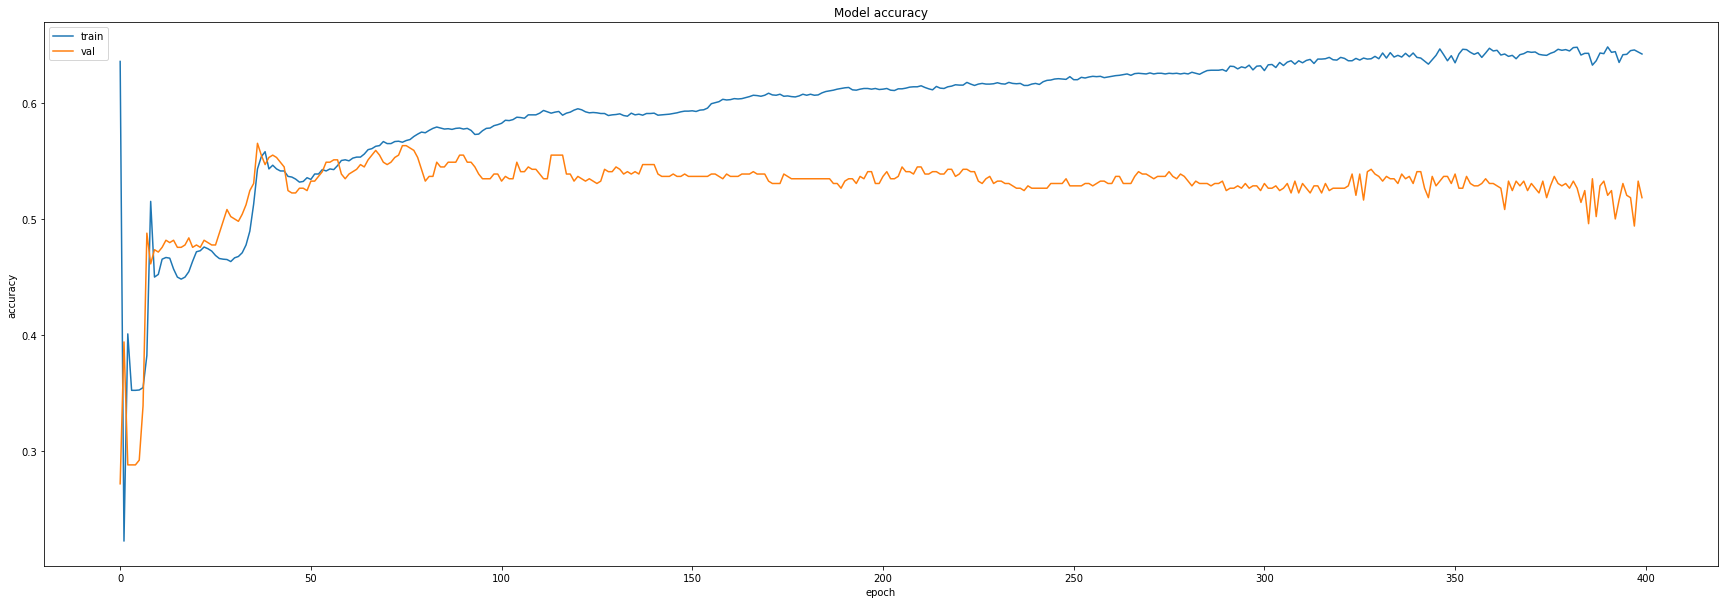

In [167]:
visualize(history,"accuracy")

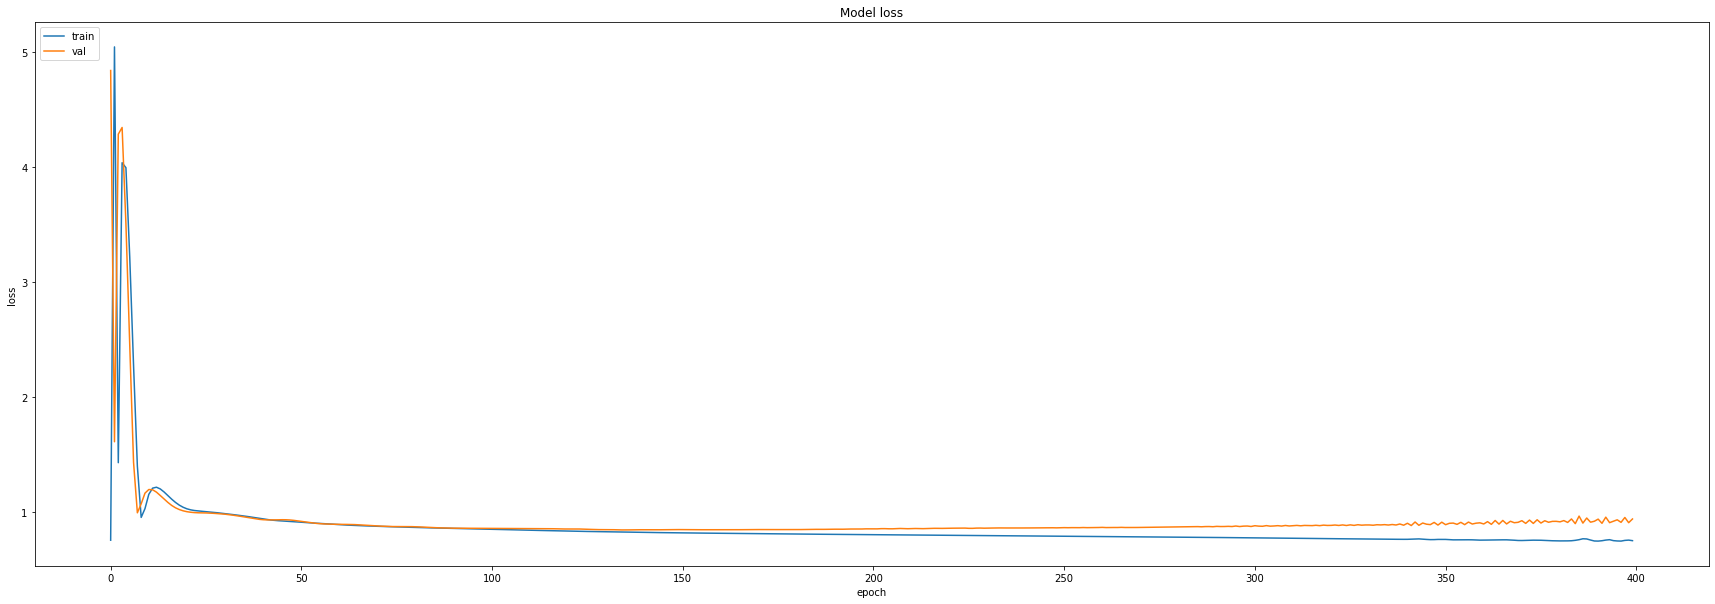

In [168]:
visualize(history,"loss")

### 5.3. Евалуација на моделот

In [175]:
evaluation_model = evaluate_model(model,test_y)
print_evaluation(evaluation_model)

Accuracy:0.5438775510204081
Precision:0.5402076953801092
F1 score:0.5260866160765049
Recall:0.5372617527083771


### 5.4. Зачувување на моделот и тежините

Да го зачуваме нашиот модел, за потоа истиот да може директно да биде вчитан со помош на `tf.keras.models.load_model(MODELNAME)`

Според докментацијата на keras, со `save` се зачувуваат:
- the model's configuration (topology)
- the model's weights
- the model's optimizer's state (if any)


In [147]:
model.save('model.h5')

## 6. Прашања и одговори

### 6.1. A. Како се менуваат перформансите на моделот доколку се промени бројот на неврони? 

Да пробаме во секој слој да го дуплираме бројот на досегашни неврони, па го довиваме следниот модел.

In [162]:
model_a = Sequential()
model_a.add(Input(11))

model_a.add(Dense(128, activation='relu', input_shape=(11,)))
model_a.add(Dense(64, activation='relu', input_shape=(11,)))
model_a.add(Dense(32, activation='relu', input_shape=(11,)))
model_a.add(Dense(16, activation='relu', input_shape=(11,)))

model_a.add(Dense(3, activation='softmax', name="output_layer"))

In [186]:
optimizer = Adam(lr=0.01)
model_a.compile(optimizer=optimizer, loss=categorical_crossentropy, metrics=['accuracy'])
history = model_a.fit(x=train_x, y=train_y, validation_split=0.125, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=0)

Да ги евалуираме метриките на новодобиениот модел

In [187]:
evaluation_model_a = evaluate_model(model_a,test_y)
print_evaluation(evaluation_model_a)

Accuracy:0.5755102040816327
Precision:0.5462677665671721
F1 score:0.5246577290370715
Recall:0.5131399851444645


Да направиме споредба со иницијалниот модел

In [190]:
comparation_a_model = compare_metrics(evaluation_model_a, evaluation_model)
print_comparation(comparation_a_model)

Δ Accuracy:0.031632653061224536
Δ Precision:0.006060071187062976
Δ F1 score:-0.0014288870394333353
Δ Recall:-0.0241217675639126


Поради позитивниот знак на разликите за accuracy и precision, може да заклучиме дека **новодобиениот модел има подобри accuracy и precision** за разлика од иницијалниот модел, но од негативниот знак кај f1 score и recall може да заклучиме дека **новодобиениот модел има полоши f1 score и recall** за разлика од иницијалниот модел.

Односно, зголемувањето на бројот на неврони, т.е. нивно дуплирање допринесе во овој случај подобрување на accuracy и precision, но намалување на f1 score и recall.

### 6.2. B. Како се менуваат перформансите на моделот доколку се промени бројот на слоеви?

Да додадеме нови скриени слоеви на иницијалниот модел.

In [191]:
model_b = Sequential()
model_b.add(Input(11))

model_b.add(Dense(16, activation='relu', input_shape=(11,))) # nov sloj
model_b.add(Dense(32, activation='relu', input_shape=(11,))) # nov sloj
model_b.add(Dense(64, activation='relu', input_shape=(11,))) # nov sloj


model_b.add(Dense(64, activation='relu', input_shape=(11,)))
model_b.add(Dense(32, activation='relu', input_shape=(11,)))

model_b.add(Dense(32, activation='relu', input_shape=(11,))) # nov sloj
model_b.add(Dense(16, activation='relu', input_shape=(11,))) # nov sloj


model_b.add(Dense(16, activation='relu', input_shape=(11,)))
model_b.add(Dense(8, activation='relu', input_shape=(11,)))

model_b.add(Dense(3, activation='softmax', name="output_layer"))

In [192]:
optimizer = Adam(lr=0.01)
model_b.compile(optimizer=optimizer, loss=categorical_crossentropy, metrics=['accuracy'])
history = model_b.fit(x=train_x, y=train_y, validation_split=0.125, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=0)

Да ги евалуираме метриките на новодобиениот модел.

In [193]:
evaluation_model_b = evaluate_model(model_b,test_y)
print_evaluation(evaluation_model_b)

Accuracy:0.4642857142857143
Precision:0.4840364220513938
F1 score:0.4580094174227618
Recall:0.48809396898414986


Да направиме споредба со иницијалниот модел

In [194]:
comparation_b_model = compare_metrics(evaluation_model_b, evaluation_model)
print_comparation(comparation_b_model)

Δ Accuracy:-0.07959183673469383
Δ Precision:-0.056171273328715354
Δ F1 score:-0.06807719865374307
Δ Recall:-0.0491677837242272


Поради негативниот знак на сите метрики, може да заклучиме дека **новодобиениот модел има послаби перформанси** за разлика од иницијалниот модел.

Односно, зголемувањето на бројот на слоеви, на начинот како што истото беше изведено доведе до намалување на сите метрики, а со тоа и целокупниот перформанс на моделот.

**Напомена:** Овој заклучок не значи секое зголемување на бројот на скриени слоеви ќе го намали перформансот, туку напротив, со додавање на нови слоеви може драстично да се подобри перформаснот, но во овој случај доделувањето го влоши перформансот на моделот.

### 6.3. C: Како се менуваат перформансите на моделот доколку се додадат слоеви за регуларизација?

На иницијалниот модел ќе му додадеме `Dropout` слој за регуларизација, и тоа на влезниот и на скриените слоеви од невронската мрежа, и ќе го добиеме следниов модел:

In [211]:
DROPOUT_RATE = 0.35

model_c = Sequential()
model_c.add(Input(11))

model_c.add(Dropout(DROPOUT_RATE, input_shape=(11,)))  # sloj za regularizacija

model_c.add(Dense(64, activation='relu', input_shape=(11,)))
model_c.add(Dropout(DROPOUT_RATE, input_shape=(11,)))  # sloj za regularizacija

model_c.add(Dense(32, activation='relu', input_shape=(11,)))
model_c.add(Dropout(DROPOUT_RATE, input_shape=(11,)))  # sloj za regularizacija

model_c.add(Dense(16, activation='relu', input_shape=(11,)))
model_c.add(Dropout(DROPOUT_RATE, input_shape=(11,)))  # sloj za regularizacija

model_c.add(Dense(8, activation='relu', input_shape=(11,)))
model_c.add(Dropout(DROPOUT_RATE, input_shape=(11,)))  # sloj za regularizacija

model_c.add(Dense(3, activation='softmax', name="output_layer"))

Kaко перпорака од оригиналниот paper за dropout e да се зголеми ратата на учење од 10 до 100 пати, во овој пример истата од 0.01 ќе биде зголемена 10х и новата рата на учење ќе изнесува **0.1**.

<a href="https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf">Линк до paper за dropout</a>

    стр. 25: A.2 Learning Rate and Momentum - делот каде што се преопрачува зголемување на ратата на учење

In [212]:
optimizer = Adam(lr=0.1)
model_c.compile(optimizer=optimizer, loss=categorical_crossentropy, metrics=['accuracy'])
history = model_c.fit(x=train_x, y=train_y, validation_split=0.125, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=0)

Да ги евалуираме метриките на новодобиениот модел.

In [213]:
evaluation_model_c = evaluate_model(model_c,test_y)
print_evaluation(evaluation_model_c)

Accuracy:0.5275510204081633
Precision:0.1758503401360544
F1 score:0.23023825428635047
Recall:0.3333333333333333


Да направиме споредба со иницијалниот модел

In [214]:
comparation_c_model = compare_metrics(evaluation_model_c, evaluation_model)
print_comparation(comparation_c_model)

Δ Accuracy:-0.01632653061224487
Δ Precision:-0.36435735524405477
Δ F1 score:-0.2958483617901544
Δ Recall:-0.20392841937504375


Поради негативниот знак на сите метрики, може да заклучиме дека **новодобиениот модел има послаби перформанси** за разлика од иницијалниот модел.

Односно, додавањето на слоеви за регуларизација, на начинот како што истото беше изведено доведе до намалување на сите метрики, а со тоа и целокупниот перформанс на моделот.

**Напомена:** Овој заклучок не значи секое додавање на слоеви за регуларизација (поконкретно `Dropout`) ќе го намали перформансот, туку напротив, регуларизирачките слоеви служат за намалување на overfitting-от и подобрување на перформансите, но во овој случај тие го влошуваат перформансот на моделот.

<hr>
Александар Ивановски - Лабораториска вежба 8 по предметот Вештачка интелигенција